# Machine Learning - Course Project

## Group 6 - Alexandre Sobreira (59451), André Dias (59452), Nihan Ahat (Not Assigned), Tiago Rodrigues (49593)

# Packages

In [3]:
import pandas as pd
import random
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score, mean_squared_error, max_error, mean_absolute_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS, add_constant
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

# Functions

In [4]:
def printRegStatistics(truth, preds):
    print("The RVE is: ", explained_variance_score(truth, preds))
    #print("The rmse is: ", mean_squared_error(truth, preds, squared=False))
    #corr, pval = pearsonr(truth, preds)
    #print("The Correlation Score is is: %6.4f (p-value=%e)"%(corr,pval))
    #print("The Maximum Error is is: ", max_error(truth, preds))
    #print("The Mean Absolute Error is: ", mean_absolute_error(truth, preds))
    
def truthplot(y_test, my_preds):
    plt.figure(figsize=(3,3))
    plt.axline([0, 0], [1, 1])
    plt.scatter(my_preds, y_test)
    plt.axis('square')
    plt.grid()
    plt.show()

def keep_regions_func(dataframe):
    regions = ['AFE','AFW','ARB','CSS','CEB','EAR','EAS','EAP','TEA','EMU','ECS','ECA','TEC','EUU','FCS','HPC','HIC','IBD','IBT','IDB','IDX','IDA','LTE','LCN','LAC','TLA','LDC','LMY','LIC','LMC','MEA','MNA','TMN','MIC','NAC','INX','OED','OSS','PSS','PST','PRE','SST','SAS','TSA','SSF','SSA','TSS','UMC','WLD']
    for region in regions:
        dataframe_regions = dataframe[dataframe['Country Code'] == region].index
        dataframe = dataframe.drop(dataframe_regions)
    dataframe = dataframe.reset_index(drop = True)
    return dataframe

def encode_func(dataframe, dataframe2):
    encoder = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
    encoded = pd.DataFrame(encoder.fit_transform(dataframe2[['Country Name']]))
    countries_encoding = dataframe.join(encoded)
    return countries_encoding

def diff_years_func(dataframe):
    diff_years_df = dataframe.copy().drop(['Country Name'], axis = 1)
    diff_years_df = diff_years_df.diff(axis = 1)
    intermediate_df = dataframe['Country Name'].copy()
    dataframe = pd.concat([intermediate_df, diff_years_df], axis = 1)
    dataframe = dataframe.drop("1960", axis = 1)
    return dataframe

def dataframe_melt_func(dataframe, target_variable_name):
    list_dataframe = dataframe.columns.values.tolist()
    list_dataframe.remove("Country Name")
    dataframe = dataframe.melt(id_vars = "Country Name", value_vars = list_dataframe, var_name = "Year", value_name = target_variable_name, col_level = None, ignore_index = True)
    return dataframe
    
def extra_variables_func(dataframe, extra_variable, keep_regions):
    extra_dataframe = pd.read_csv(extra_variable, header = 2)
    if keep_regions == False:
        extra_dataframe = keep_regions_func(extra_dataframe)
    extra_dataframe.drop(["Country Code", "Indicator Name", "Indicator Code"], axis = 1, inplace = True)
    extra_dataframe = dataframe_melt_func(extra_dataframe, extra_variable)
    extra_dataframe = extra_dataframe.loc[extra_dataframe['Year'] < str(2017)]
    dataframe = dataframe.merge(extra_dataframe, how = 'left', on = ['Country Name', 'Year'])
    dataframe[extra_variable] = pd.to_numeric(dataframe[extra_variable])
    return dataframe

def prepare_x_test(extra_variables, countries_encoding, coutries_encoding, dataframe_2017, dataframe_2018, encoding = True):
    X_test_2017, X_test_2018, truth_values_2017, truth_values_2018 = [], [], [], []
    for country in coutries_encoding:
        if encoding == True:
            if len(extra_variables) != 0:  
                if type(extra_variables) == str:
                    extra_dataframe = pd.read_csv(extra_variables, header = 2)
                    value_2017 = extra_dataframe['2017'][(extra_dataframe['Country Name'] == country)].values
                    value_2018 = extra_dataframe['2018'][(extra_dataframe['Country Name'] == country)].values
                    test_2017 = np.append(np.array([2017]), value_2017)
                    test_2018 = np.append(np.array([2018]), value_2018)
                else:
                    value_2017, value_2018 = [], []
                    for extra_variable in extra_variables:
                        extra_dataframe = pd.read_csv(extra_variable, header = 2)
                        value_2017.append(extra_dataframe['2017'][(extra_dataframe['Country Name'] == country)].values)
                        value_2018.append(extra_dataframe['2018'][(extra_dataframe['Country Name'] == country)].values)
                    test_2017 = np.append(np.array([2017]), np.array(value_2017))
                    test_2018 = np.append(np.array([2018]), np.array(value_2018))
                X_test_2017.append(np.append(test_2017, countries_encoding[countries_encoding['Country Name'] == country].copy().drop('Country Name', axis = 1).values))
                X_test_2018.append(np.append(test_2018, countries_encoding[countries_encoding['Country Name'] == country].copy().drop('Country Name', axis = 1).values))
            else:
                X_test_2017.append(np.append(np.array([2017]), countries_encoding[countries_encoding['Country Name'] == country].copy().drop('Country Name', axis = 1).values))
                X_test_2018.append(np.append(np.array([2020]), countries_encoding[countries_encoding['Country Name'] == country].copy().drop('Country Name', axis = 1).values))
        else:
            if len(extra_variables) != 0:  
                if type(extra_variables) == str:
                    extra_dataframe = pd.read_csv(extra_variables, header = 2)
                    value_2017 = extra_dataframe['2017'][(extra_dataframe['Country Name'] == country)].values
                    value_2018 = extra_dataframe['2018'][(extra_dataframe['Country Name'] == country)].values
                    X_test_2017.append(np.append(np.array([2017]), value_2017))
                    X_test_2018.append(np.append(np.array([2018]), value_2018))
                else:
                    value_2017, value_2018 = [], []
                    for extra_variable in extra_variables:
                        extra_dataframe = pd.read_csv(extra_variable, header = 2)
                        value_2017.append(extra_dataframe['2017'][(extra_dataframe['Country Name'] == country)].values)
                        value_2018.append(extra_dataframe['2018'][(extra_dataframe['Country Name'] == country)].values)
                    X_test_2017.append(np.append(np.array([2017]), value_2017))
                    X_test_2018.append(np.append(np.array([2018]), value_2018))
            else:
                X_test_2017.append(np.array([2017]))
                X_test_2018.append(np.array([2018]))
        truth_values_2017.append(dataframe_2017['2017'][dataframe_2017['Country Name'] == country].values)
        truth_values_2018.append(dataframe_2018['2018'][dataframe_2018['Country Name'] == country].values)
    return X_test_2017, X_test_2018, truth_values_2017, truth_values_2018
        
def country_encoding_df(csv_file, keep_regions = True):
    dataframe = pd.read_csv(csv_file)
    dataframev2 = dataframe[['Country Name','Country Code']]
    if keep_regions == False:
        dataframev2 = keep_regions_func(dataframev2)
    countries_encoding = encode_func(dataframev2, dataframev2)
    countries_encoding = countries_encoding.drop('Country Code', axis = 1)
    return countries_encoding

def maketraindataset(csv_file, target_variable_name, extra_variables, keep_regions = True, diff_years = True, encoding = True, less_years = True):
    dataframe = pd.read_csv(csv_file)            
    if keep_regions == False:
        dataframe = keep_regions_func(dataframe)
    dataframe.drop(["Country Code", "Indicator Name", "Indicator Code"], axis = 1, inplace = True)
    if diff_years == True:
        dataframe = diff_years_func(dataframe)
    dataframe = dataframe_melt_func(dataframe, target_variable_name)
    if len(extra_variables) != 0:  
        if type(extra_variables) == str:
            dataframe = extra_variables_func(dataframe, extra_variables, keep_regions)
        else:
            for extra_variable in extra_variables:
                dataframe = extra_variables_func(dataframe, extra_variable, keep_regions)
    if encoding == True:
        dataframe = encode_func(dataframe, dataframe)
    if less_years == True:
        dataframe = dataframe.loc[dataframe['Year'] > str(2000)]
    dataframe = dataframe.dropna()
    dataframe = dataframe.reset_index(drop = True)
    dataframe['Year'] = pd.to_numeric(dataframe['Year'])
    y_data = dataframe[target_variable_name].copy()
    X_data = dataframe.copy().drop([target_variable_name], axis = 1)
    return X_data, y_data

def make2017_2018(csv_file, csv_file_data, numheadercolumns, keep_regions = True, diff_years = True, encode = True):
    dataframe = pd.read_csv(csv_file, header = numheadercolumns)
    dataframe_data = pd.read_csv(csv_file_data)
    if keep_regions == False:
        dataframe = keep_regions_func(dataframe)
        dataframe_data = keep_regions_func(dataframe_data)
    dataframe.drop(["Country Code", "Indicator Name", "Indicator Code"], axis = 1, inplace = True)
    if diff_years == True:
        dataframe = diff_years_func(dataframe)
    dataframe = dataframe[['Country Name', '2017', '2018']]
    if encode == True:
        dataframe = encode_func(dataframe, dataframe_data)
    dataframe['2017'] = pd.to_numeric(dataframe['2017'])
    dataframe['2018'] = pd.to_numeric(dataframe['2018'])
    dataframe_2017 = dataframe.copy().drop('2018', axis = 1)
    dataframe_2018 = dataframe.copy().drop('2017', axis = 1)
    return dataframe_2017, dataframe_2018

def modelfitevaluation(csv_file_data, csv_file_target, numheadercolumns, target_variable_name, model_type, chosen_countries, extra_variables, params_grid_search, keep_regions = True, diff_years = True, encoding = True, less_years = True, plots = False):
    X_data, y_data = maketraindataset(csv_file_data, target_variable_name, extra_variables, keep_regions, diff_years, encoding, less_years)
    dataframe_2017, dataframe_2018 = make2017_2018(csv_file_target, csv_file_data, numheadercolumns, keep_regions, diff_years, encoding)
    countries_encoding = country_encoding_df(csv_file_data, keep_regions)
    X_test_2017, X_test_2018, truth_values_2017, truth_values_2018 = prepare_x_test(extra_variables, countries_encoding, chosen_countries, dataframe_2017, dataframe_2018, encoding)
    X_data = X_data.drop('Country Name', axis = 1).to_numpy()
    y_data = y_data.to_numpy()
    truth_values_2017 = np.squeeze(truth_values_2017)
    truth_values_2018 = np.squeeze(truth_values_2018)
    if len(params_grid_search) != 0:
        gs = GridSearchCV(estimator = model_type, param_grid = params_grid_search, scoring = 'explained_variance', n_jobs = -1, cv = 10).fit(X_data, y_data)
        print('The best model for 2017 based on explained_variance is:')
        print(gs.best_params_)
        predictions_2017_gs = gs.best_estimator_.predict(X_test_2017)
        print('For the tunned model the statistics are:')
        printRegStatistics(truth_values_2017, predictions_2017_gs)
        if plots == True:
            truthplot(truth_values_2017, predictions_2017_gs)
        print('The best model for 2018 based on explained_variance is:')
        print(gs.best_params_)
        predictions_2018_gs = gs.best_estimator_.predict(X_test_2018)
        print('For the tunned model the statistics are:')
        printRegStatistics(truth_values_2018, predictions_2018_gs)
        if plots == True:
            truthplot(truth_values_2018, predictions_2018_gs)
            print('These are the truth values of 2017:', truth_values_2017.astype(float))
            print('These are the predictions of 2017:', predictions_2017_gs.astype(float))
            print('These are the truth values of 2018:', truth_values_2018.astype(float))
            print('These are the predictions of 2018:', predictions_2018_gs.astype(float))
        
    else:
        model = model_type.fit(X_data, y_data)
        predictions_2017 = model.predict(X_test_2017)
        predictions_2018 = model.predict(X_test_2018)
        print('For 2017:')
        printRegStatistics(truth_values_2017, predictions_2017)
        if plots == True:
            truthplot(truth_values_2017, predictions_2017)        
        print('For 2018:')
        printRegStatistics(truth_values_2018, predictions_2018)
        if plots == True:
            truthplot(truth_values_2018, predictions_2018) 
            print('These are the truth values of 2017:', truth_values_2017.astype(float))
            print('These are the predictions of 2017:', predictions_2017.astype(float))
            print('These are the truth values of 2018:', truth_values_2018.astype(float))
            print('These are the predictions of 2018:', predictions_2018.astype(float))

# Random Countries choosen

In [5]:
# choose 10 random countries
df = pd.read_csv('country_population.csv')
regions = ['AFE','AFW','ARB','CSS','CEB','EAR','EAS','EAP','TEA','EMU','ECS','ECA','TEC','EUU','FCS','HPC','HIC','IBD','IBT','IDB','IDX','IDA','LTE','LCN','LAC','TLA','LDC','LMY','LIC','LMC','MEA','MNA','TMN','MIC','NAC','INX','OED','OSS','PSS','PST','PRE','SST','SAS','TSA','SSF','SSA','TSS','UMC','WLD']
for region in regions:
    index_list = df[df['Country Code'] == region].index
    df = df.drop(index_list)
chosen_countries = list(df['Country Name'].sample(n = 10, random_state = 123).values)
print(chosen_countries)

['United States', 'Uruguay', 'Central African Republic', 'Seychelles', 'Senegal', 'Saudi Arabia', 'India', 'Lesotho', 'Luxembourg', 'Kenya']


# Models with one hot encoding

#### Linear Regression

In [6]:
# Applying dropna(), OHE to the melt datasets
print("country_population")
modelfitevaluation("country_population.csv", 'country_population_2017_2018.csv', 2, "Country_population", LinearRegression(), chosen_countries, [], [], True, False, True, False, False)
print("life_expectancy")
modelfitevaluation("life_expectancy.csv", 'life_expectancy_2017_2018.csv', 2, "life_expectancy", LinearRegression(), chosen_countries, [], [], True, False, True, False, False)
print("fertility_rate")
modelfitevaluation("fertility_rate.csv", 'fertility_rate_2017_2018.csv', 2, "fertility_rate", LinearRegression(), chosen_countries, [], [], True, False, True, False, False)

country_population
For 2017:
The RVE is:  0.8657970952387285
For 2018:
The RVE is:  0.8607840769226619
life_expectancy
For 2017:
The RVE is:  0.8048110640276782
For 2018:
The RVE is:  0.7864589009157704
fertility_rate
For 2017:
The RVE is:  0.4437980267552343
For 2018:
The RVE is:  0.44301765870338483


#### Random Forests

country_population
For 2017:
The RVE is:  0.9992465589937498


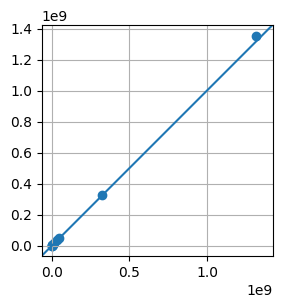

For 2018:
The RVE is:  0.9985708564220143


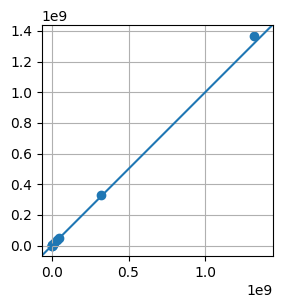

These are the truth values of 2017: [3.25122128e+08 3.42220000e+06 4.99674100e+06 9.58430000e+04
 1.51577930e+07 3.41931220e+07 1.35419568e+09 2.17061700e+06
 5.96336000e+05 4.89481370e+07]
These are the predictions of 2017: [3.22068004e+08 3.43625269e+06 4.57494766e+06 9.36804000e+04
 1.51733372e+07 3.18168230e+07 1.31672908e+09 2.18760876e+06
 5.73032150e+05 4.78660423e+07]
These are the truth values of 2018: [3.26838199e+08 3.42704200e+06 5.09478000e+06 9.67620000e+04
 1.55749090e+07 3.50181330e+07 1.36900331e+09 2.19801700e+06
 6.07950000e+05 4.99533040e+07]
These are the predictions of 2018: [3.22068004e+08 3.43625269e+06 4.57494766e+06 9.36804000e+04
 1.51733372e+07 3.18168230e+07 1.31672908e+09 2.18760876e+06
 5.73032150e+05 4.78660423e+07]
life_expectancy
For 2017:
The RVE is:  0.965205187812525
For 2018:
The RVE is:  0.9585497355719466
fertility_rate
For 2017:
The RVE is:  0.9210206431950347
For 2018:
The RVE is:  0.9165898862529758


In [7]:
# Applying dropna(), OHE to the melt datasets
print("country_population")
modelfitevaluation("country_population.csv", 'country_population_2017_2018.csv', 2, "Country_population", RandomForestRegressor(random_state = 123), chosen_countries, [], [], True, False, True, False, True)
print("life_expectancy")
modelfitevaluation("life_expectancy.csv", 'life_expectancy_2017_2018.csv', 2, "life_expectancy", RandomForestRegressor(random_state = 123), chosen_countries, [], [], True, False, True, False, False)
print("fertility_rate")
modelfitevaluation("fertility_rate.csv", 'fertility_rate_2017_2018.csv', 2, "fertility_rate", RandomForestRegressor(random_state = 123), chosen_countries, [], [], True, False, True, False, False)

#### XGBoost (Regression)

In [8]:
# Applying dropna(), OHE to the melt datasets
print("country_population")
modelfitevaluation("country_population.csv", 'country_population_2017_2018.csv', 2, "Country_population", XGBRegressor(seed = 123), chosen_countries, [], [], True, False, True, False, False)
print("life_expectancy")
modelfitevaluation("life_expectancy.csv", 'life_expectancy_2017_2018.csv', 2, "life_expectancy", XGBRegressor(seed = 123), chosen_countries, [], [], True, False, True, False, False)
print("fertility_rate")
modelfitevaluation("fertility_rate.csv", 'fertility_rate_2017_2018.csv', 2, "fertility_rate", XGBRegressor(seed = 123), chosen_countries, [], [], True, False, True, False, False)

country_population
For 2017:
The RVE is:  0.9851906059184458
For 2018:
The RVE is:  0.9830599130562805
life_expectancy
For 2017:
The RVE is:  0.9166010412813521
For 2018:
The RVE is:  0.9208093340971183
fertility_rate
For 2017:
The RVE is:  0.7904892355722178
For 2018:
The RVE is:  0.7873120356388985


## Removing groups of countries

#### Linear Regression

In [9]:
# Applying dropna(), OHE, drop_groups to the melt datasets
print("country_population")
modelfitevaluation("country_population.csv", 'country_population_2017_2018.csv', 2, "Country_population", LinearRegression(), chosen_countries, [], [], False, False, True, False, False)
print("life_expectancy")
modelfitevaluation("life_expectancy.csv", 'life_expectancy_2017_2018.csv', 2, "life_expectancy", LinearRegression(), chosen_countries, [], [], False, False, True, False, False)
print("fertility_rate")
modelfitevaluation("fertility_rate.csv", 'fertility_rate_2017_2018.csv', 2, "fertility_rate", LinearRegression(), chosen_countries, [], [], False, False, True, False, False)

country_population
For 2017:
The RVE is:  0.8657970952387289
For 2018:
The RVE is:  0.8607840769226625
life_expectancy
For 2017:
The RVE is:  0.8045629597361676
For 2018:
The RVE is:  0.7860031833915503
fertility_rate
For 2017:
The RVE is:  0.4437382809829342
For 2018:
The RVE is:  0.44295379016263614


#### Random Forests

In [10]:
# Applying dropna(), OHE, drop_groups to the melt datasets
print("country_population")
modelfitevaluation("country_population.csv", 'country_population_2017_2018.csv', 2, "Country_population", RandomForestRegressor(random_state = 123), chosen_countries, [], [], False, False, True, False, False)
print("life_expectancy")
modelfitevaluation("life_expectancy.csv", 'life_expectancy_2017_2018.csv', 2, "life_expectancy", RandomForestRegressor(random_state = 123), chosen_countries, [], [], False, False, True, False, False)
print("fertility_rate")
modelfitevaluation("fertility_rate.csv", 'fertility_rate_2017_2018.csv', 2, "fertility_rate", RandomForestRegressor(random_state = 123), chosen_countries, [], [], False, False, True, False, False)

country_population
For 2017:
The RVE is:  0.9992360006732952
For 2018:
The RVE is:  0.9985562404129289
life_expectancy
For 2017:
The RVE is:  0.9632779673350497
For 2018:
The RVE is:  0.9568095075533105
fertility_rate
For 2017:
The RVE is:  0.921596542457477
For 2018:
The RVE is:  0.9172724384635254


#### XGBoost (Regression)

In [11]:
# Applying dropna(), OHE, drop_groups to the melt datasets
print("country_population")
modelfitevaluation("country_population.csv", 'country_population_2017_2018.csv', 2, "Country_population", XGBRegressor(seed = 123), chosen_countries, [], [], False, False, True, False, False)
print("life_expectancy")
modelfitevaluation("life_expectancy.csv", 'life_expectancy_2017_2018.csv', 2, "life_expectancy", XGBRegressor(seed = 123), chosen_countries, [], [], False, False, True, False, False)
print("fertility_rate")
modelfitevaluation("fertility_rate.csv", 'fertility_rate_2017_2018.csv', 2, "fertility_rate", XGBRegressor(seed = 123), chosen_countries, [], [], False, False, True, False, False)

country_population
For 2017:
The RVE is:  0.9983334658550246
For 2018:
The RVE is:  0.9974371512413389
life_expectancy
For 2017:
The RVE is:  0.9342831218644425
For 2018:
The RVE is:  0.9343796268075111
fertility_rate
For 2017:
The RVE is:  0.8770957399095857
For 2018:
The RVE is:  0.873044231976185


## Using Deltas

#### Linear Regression

In [12]:
# Applying dropna(), OHE, drop_groups, deltas to the melt datasets
print("country_population")
modelfitevaluation("country_population.csv", 'country_population_2017_2018.csv', 2, "Country_population", LinearRegression(), chosen_countries, [], [], False, True, True, False, False)
print("life_expectancy")
modelfitevaluation("life_expectancy.csv", 'life_expectancy_2017_2018.csv', 2, "life_expectancy", LinearRegression(), chosen_countries, [], [], False, True, True, False, False)
print("fertility_rate")
modelfitevaluation("fertility_rate.csv", 'fertility_rate_2017_2018.csv', 2, "fertility_rate", LinearRegression(), chosen_countries, [], [], False, True, True, False, False)

country_population
For 2017:
The RVE is:  0.9977823311159253
For 2018:
The RVE is:  0.9919942132546362
life_expectancy
For 2017:
The RVE is:  -0.11512510488391192
For 2018:
The RVE is:  0.06106955557341587
fertility_rate
For 2017:
The RVE is:  -0.09063025823137116
For 2018:
The RVE is:  -0.42744599459264876


#### Random Forests

In [13]:
# Applying dropna(), OHE, drop_groups, deltas to the melt datasets
print("country_population")
modelfitevaluation("country_population.csv", 'country_population_2017_2018.csv', 2, "Country_population", RandomForestRegressor(random_state = 123), chosen_countries, [], [], False, True, True, False, False)
print("life_expectancy")
modelfitevaluation("life_expectancy.csv", 'life_expectancy_2017_2018.csv', 2, "life_expectancy", RandomForestRegressor(random_state = 123), chosen_countries, [], [], False, True, True, False, False)
print("fertility_rate")
modelfitevaluation("fertility_rate.csv", 'fertility_rate_2017_2018.csv', 2, "fertility_rate", RandomForestRegressor(random_state = 123), chosen_countries, [], [], False, True, True, False, False)

country_population
For 2017:
The RVE is:  0.9989274050518746
For 2018:
The RVE is:  0.9979232727636559
life_expectancy
For 2017:
The RVE is:  0.3183722425504505
For 2018:
The RVE is:  0.12390207311526757
fertility_rate
For 2017:
The RVE is:  -2.1773819826553007
For 2018:
The RVE is:  -4.465646883236452


#### XGBoost (Regression)

In [14]:
# Applying dropna(), OHE, drop_groups, deltas to the melt datasets
print("country_population")
modelfitevaluation("country_population.csv", 'country_population_2017_2018.csv', 2, "Country_population", XGBRegressor(seed = 123), chosen_countries, [], [], False, True, True, False, False)
print("life_expectancy")
modelfitevaluation("life_expectancy.csv", 'life_expectancy_2017_2018.csv', 2, "life_expectancy", XGBRegressor(seed = 123), chosen_countries, [], [], False, True, True, False, False)
print("fertility_rate")
modelfitevaluation("fertility_rate.csv", 'fertility_rate_2017_2018.csv', 2, "fertility_rate", XGBRegressor(seed = 123), chosen_countries, [], [], False, True, True, False, False)

country_population
For 2017:
The RVE is:  0.9985678991706611
For 2018:
The RVE is:  0.9976232604700943
life_expectancy
For 2017:
The RVE is:  0.1752655209992936
For 2018:
The RVE is:  0.15908598548169728
fertility_rate
For 2017:
The RVE is:  -1.290150253020855
For 2018:
The RVE is:  -2.907493053254485


## Less data (2000 - 2016)

#### Linear Regression

In [15]:
# Applying dropna(), OHE, drop_groups, less data to the melt datasets
print("country_population")
modelfitevaluation("country_population.csv", 'country_population_2017_2018.csv', 2, "Country_population", LinearRegression(), chosen_countries, [], [], False, True, True, True, False)
print("life_expectancy")
modelfitevaluation("life_expectancy.csv", 'life_expectancy_2017_2018.csv', 2, "life_expectancy", LinearRegression(), chosen_countries, [], [], False, True, True, True, False)
print("fertility_rate")
modelfitevaluation("fertility_rate.csv", 'fertility_rate_2017_2018.csv', 2, "fertility_rate", LinearRegression(), chosen_countries, [], [], False, True, True, True, False)

country_population
For 2017:
The RVE is:  0.9909330008825575
For 2018:
The RVE is:  0.976034580755055
life_expectancy
For 2017:
The RVE is:  -0.019169050535840615
For 2018:
The RVE is:  0.19654792992885328
fertility_rate
For 2017:
The RVE is:  -0.29475405952465783
For 2018:
The RVE is:  -0.6599938903581644


#### Random Forests

In [16]:
# Applying dropna(), OHE, drop_groups, less data to the melt datasets
print("country_population")
modelfitevaluation("country_population.csv", 'country_population_2017_2018.csv', 2, "Country_population", RandomForestRegressor(random_state = 123), chosen_countries, [], [], False, True, True, True, False)
print("life_expectancy")
modelfitevaluation("life_expectancy.csv", 'life_expectancy_2017_2018.csv', 2, "life_expectancy", RandomForestRegressor(random_state = 123), chosen_countries, [], [], False, True, True, True, False)
print("fertility_rate")
modelfitevaluation("fertility_rate.csv", 'fertility_rate_2017_2018.csv', 2, "fertility_rate", RandomForestRegressor(random_state = 123), chosen_countries, [], [], False, True, True, True, False)

country_population
For 2017:
The RVE is:  0.9989191613188637
For 2018:
The RVE is:  0.9979951946623377
life_expectancy
For 2017:
The RVE is:  0.32631304040627573
For 2018:
The RVE is:  0.07741754022221004
fertility_rate
For 2017:
The RVE is:  -1.9225870148675188
For 2018:
The RVE is:  -3.9807463111528323


#### XGBoost (Regression)

In [17]:
# Applying dropna(), OHE, drop_groups, less data to the melt datasets
print("country_population")
modelfitevaluation("country_population.csv", 'country_population_2017_2018.csv', 2, "Country_population", XGBRegressor(seed = 123), chosen_countries, [], [], False, True, True, True, False)
print("life_expectancy")
modelfitevaluation("life_expectancy.csv", 'life_expectancy_2017_2018.csv', 2, "life_expectancy", XGBRegressor(seed = 123), chosen_countries, [], [], False, True, True, True, False)
print("fertility_rate")
modelfitevaluation("fertility_rate.csv", 'fertility_rate_2017_2018.csv', 2, "fertility_rate", XGBRegressor(seed = 123), chosen_countries, [], [], False, True, True, True, False)

country_population
For 2017:
The RVE is:  0.9987364065908412
For 2018:
The RVE is:  0.9982914317022596
life_expectancy
For 2017:
The RVE is:  0.20518059698596203
For 2018:
The RVE is:  0.1661955046699618
fertility_rate
For 2017:
The RVE is:  -1.6139866124243754
For 2018:
The RVE is:  -3.5767721903353147


## Variables

#### Linear Regression

In [18]:
# Applying dropna(), OHE, drop_groups, less data to the melt datasets
print("country_population + Urban Pop")
modelfitevaluation("country_population.csv", 'country_population_2017_2018.csv', 2, "Country_population", LinearRegression(), chosen_countries, 'urban_pop.csv', [], False, True, True, True, False)
print("country_population + Urban Pop + Income")
modelfitevaluation("country_population.csv", 'country_population_2017_2018.csv', 2, "Country_population", LinearRegression(), chosen_countries, ['urban_pop.csv', 'Income.csv'], [], False, True, True, True, False)
print("life_expectancy + Urban Pop")
modelfitevaluation("life_expectancy.csv", 'life_expectancy_2017_2018.csv', 2, "life_expectancy", LinearRegression(), chosen_countries, 'urban_pop.csv', [], False, True, True, True, False)
print("life_expectancy + Urban Pop + Income")
modelfitevaluation("life_expectancy.csv", 'life_expectancy_2017_2018.csv', 2, "life_expectancy", LinearRegression(), chosen_countries, ['urban_pop.csv', 'Income.csv'], [], False, True, True, True, False)
print("fertility_rate + Urban Pop")
modelfitevaluation("fertility_rate.csv", 'fertility_rate_2017_2018.csv', 2, "Fertility_rate", LinearRegression(), chosen_countries, 'urban_pop.csv', [], False, True, True, True, False)
print("fertility_rate + Urban Pop + Income")
modelfitevaluation("fertility_rate.csv", 'fertility_rate_2017_2018.csv', 2, "Fertility_rate", LinearRegression(), chosen_countries, ['urban_pop.csv', 'Income.csv'], [], False, True, True, True, False)

country_population + Urban Pop
For 2017:
The RVE is:  0.9972559144510446
For 2018:
The RVE is:  0.9891563044444935
country_population + Urban Pop + Income
For 2017:
The RVE is:  0.9966999205361295
For 2018:
The RVE is:  0.9881717653321743
life_expectancy + Urban Pop
For 2017:
The RVE is:  -0.04966710193397783
For 2018:
The RVE is:  0.18472487649874791
life_expectancy + Urban Pop + Income
For 2017:
The RVE is:  -0.054238375683421935
For 2018:
The RVE is:  0.19175498395325652
fertility_rate + Urban Pop
For 2017:
The RVE is:  -0.2939922742144718
For 2018:
The RVE is:  -0.7048058129966484
fertility_rate + Urban Pop + Income
For 2017:
The RVE is:  -0.28170300541430104
For 2018:
The RVE is:  -0.6812193199585344


#### Random Forests

In [19]:
# Applying dropna(), OHE, drop_groups, less data to the melt datasets
print("country_population + Urban Pop")
modelfitevaluation("country_population.csv", 'country_population_2017_2018.csv', 2, "Country_population", RandomForestRegressor(random_state = 123), chosen_countries, 'urban_pop.csv', [], False, True, True, True, False)
print("country_population + Urban Pop + Income")
modelfitevaluation("country_population.csv", 'country_population_2017_2018.csv', 2, "Country_population", RandomForestRegressor(random_state = 123), chosen_countries, ['urban_pop.csv', 'Income.csv'], [], False, True, True, True, False)
print("life_expectancy + Urban Pop")
modelfitevaluation("life_expectancy.csv", 'life_expectancy_2017_2018.csv', 2, "life_expectancy", RandomForestRegressor(random_state = 123), chosen_countries, 'urban_pop.csv', [], False, True, True, True, False)
print("life_expectancy + Urban Pop + Income")
modelfitevaluation("life_expectancy.csv", 'life_expectancy_2017_2018.csv', 2, "life_expectancy", RandomForestRegressor(random_state = 123), chosen_countries, ['urban_pop.csv', 'Income.csv'], [], False, True, True, True, False)
print("fertility_rate + Urban Pop")
modelfitevaluation("fertility_rate.csv", 'fertility_rate_2017_2018.csv', 2, "Fertility_rate", RandomForestRegressor(random_state = 123), chosen_countries, 'urban_pop.csv', [], False, True, True, True, False)
print("fertility_rate + Urban Pop + Income")
modelfitevaluation("fertility_rate.csv", 'fertility_rate_2017_2018.csv', 2, "Fertility_rate", RandomForestRegressor(random_state = 123), chosen_countries, ['urban_pop.csv', 'Income.csv'], [], False, True, True, True, False)

country_population + Urban Pop
For 2017:
The RVE is:  0.994532254822954
For 2018:
The RVE is:  0.9935368891754764
country_population + Urban Pop + Income
For 2017:
The RVE is:  0.9966341650993552
For 2018:
The RVE is:  0.9897691215016395
life_expectancy + Urban Pop
For 2017:
The RVE is:  0.35181042776168536
For 2018:
The RVE is:  0.07069535035619756
life_expectancy + Urban Pop + Income
For 2017:
The RVE is:  0.34004121267701715
For 2018:
The RVE is:  0.14687290056427116
fertility_rate + Urban Pop
For 2017:
The RVE is:  -1.5880278171700444
For 2018:
The RVE is:  -3.3383862730620626
fertility_rate + Urban Pop + Income
For 2017:
The RVE is:  -1.92596118060227
For 2018:
The RVE is:  -4.030797914756105


#### XGBoost (Regression)

In [20]:
# Applying dropna(), OHE, drop_groups, less data to the melt datasets
print("country_population + Urban Pop")
modelfitevaluation("country_population.csv", 'country_population_2017_2018.csv', 2, "Country_population", XGBRegressor(seed = 123), chosen_countries, 'urban_pop.csv', [], False, True, True, True, False)
print("country_population + Urban Pop + Income")
modelfitevaluation("country_population.csv", 'country_population_2017_2018.csv', 2, "Country_population", XGBRegressor(seed = 123), chosen_countries, ['urban_pop.csv', 'Income.csv'], [], False, True, True, True, False)
print("life_expectancy + Urban Pop")
modelfitevaluation("life_expectancy.csv", 'life_expectancy_2017_2018.csv', 2, "life_expectancy", XGBRegressor(seed = 123), chosen_countries, 'urban_pop.csv', [], False, True, True, True, False)
print("life_expectancy + Urban Pop + Income")
modelfitevaluation("life_expectancy.csv", 'life_expectancy_2017_2018.csv', 2, "life_expectancy", XGBRegressor(seed = 123), chosen_countries, ['urban_pop.csv', 'Income.csv'], [], False, True, True, True, False)
print("fertility_rate + Urban Pop")
modelfitevaluation("fertility_rate.csv", 'fertility_rate_2017_2018.csv', 2, "Fertility_rate", XGBRegressor(seed = 123), chosen_countries, 'urban_pop.csv', [], False, True, True, True, False)
print("fertility_rate + Urban Pop + Income")
modelfitevaluation("fertility_rate.csv", 'fertility_rate_2017_2018.csv', 2, "Fertility_rate", XGBRegressor(seed = 123), chosen_countries, ['urban_pop.csv', 'Income.csv'], [], False, True, True, True, False)

country_population + Urban Pop
For 2017:
The RVE is:  0.9989276295853723
For 2018:
The RVE is:  0.8365025241265921
country_population + Urban Pop + Income
For 2017:
The RVE is:  0.9988951581307675
For 2018:
The RVE is:  0.8368948306982968
life_expectancy + Urban Pop
For 2017:
The RVE is:  0.20254545106897315
For 2018:
The RVE is:  0.23033338425823946
life_expectancy + Urban Pop + Income
For 2017:
The RVE is:  0.2275976183070999
For 2018:
The RVE is:  0.11861091459864492
fertility_rate + Urban Pop
For 2017:
The RVE is:  -1.194739644131837
For 2018:
The RVE is:  -2.737827992669195
fertility_rate + Urban Pop + Income
For 2017:
The RVE is:  -1.676379942152486
For 2018:
The RVE is:  -3.4157701269869367


# Grid Search

The best model for 2017 based on explained_variance is:
{'criterion': 'poisson', 'max_depth': None, 'n_estimators': 150}
For the tunned model the statistics are:
The RVE is:  0.9185484553105759


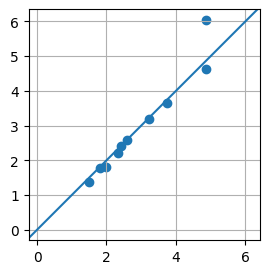

The best model for 2018 based on explained_variance is:
{'criterion': 'poisson', 'max_depth': None, 'n_estimators': 150}
For the tunned model the statistics are:
The RVE is:  0.9165882653670472


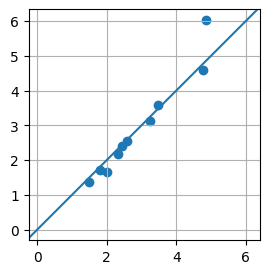

These are the truth values of 2017: [1.7655 1.796  6.048  2.41   4.622  2.584  2.2    3.187  1.39   3.643 ]
These are the predictions of 2017: [1.81870667 1.99746667 4.8555     2.43172    4.85737333 2.57843333
 2.33998    3.21140667 1.49668333 3.74822667]
These are the truth values of 2018: [1.7295 1.658  6.037  2.41   4.584  2.546  2.177  3.139  1.38   3.58  ]
These are the predictions of 2018: [1.81870667 1.99746667 4.85788667 2.44586667 4.77532    2.58227467
 2.33504667 3.24194    1.49524333 3.46349333]
The best model for 2017 based on explained_variance is:
{'copy_X': True, 'fit_intercept': True}
For the tunned model the statistics are:
The RVE is:  0.9740276044231367


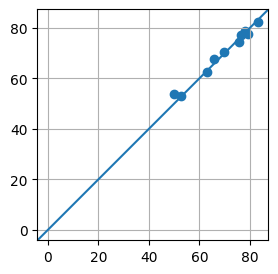

The best model for 2018 based on explained_variance is:
{'copy_X': True, 'fit_intercept': True}
For the tunned model the statistics are:
The RVE is:  0.9572386270288344


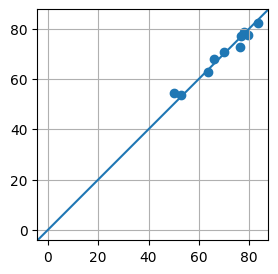

These are the truth values of 2017: [78.53902439 77.625      53.721      74.3        67.75       77.16
 70.467      53.064      82.09512195 62.481     ]
These are the predictions of 2017: [78.21669127 79.2066606  49.92781485 75.83274961 65.84452229 76.39458476
 69.642775   52.60305095 83.11276446 63.18340812]
These are the truth values of 2018: [78.63902439 77.611      54.369      72.84146341 68.097      77.212
 70.71       53.733      82.29512195 62.676     ]
These are the predictions of 2018: [77.91254707 79.54782334 50.27009251 76.17391737 66.18959409 76.66781242
 70.16581864 52.94441562 83.45075746 63.52791667]


In [21]:
# fertility_Rate
grid_fert = {'n_estimators': [50, 100, 150], 'criterion': ['squared_error', 'friedman_mse', 'poisson'], 'max_depth': [5, 10, None]}
modelfitevaluation("fertility_rate.csv", 'fertility_rate_2017_2018.csv', 2, "fertility_rate", RandomForestRegressor(random_state = 123), chosen_countries, ['urban_pop.csv', 'Income.csv'], grid_fert, False, False, True, True, True)

# life_expectancy
grid_exp = {'fit_intercept':[True,False], 'copy_X':[True, False]}
modelfitevaluation("life_expectancy.csv", 'life_expectancy_2017_2018.csv', 2, "life_expectancy", LinearRegression(), chosen_countries, ['urban_pop.csv', 'Income.csv'], grid_exp, False, False, True, True, True)
